# Model results

In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib import patches as mpatches
from mpl_toolkits.basemap import Basemap

import seaborn as sns

import os, sys

In [2]:
# Value to change to get correct paths
data_path = './data/'

In [3]:
inputs_path = data_path
intermediate_path = data_path + 'intermediate/'
output_path = data_path + 'outputs/with_irrig/'

base_path = inputs_path + 'Base/'
diet_path = inputs_path + 'diet/'
pop_path = inputs_path + 'population/'

data_2000_path = intermediate_path + 'Baseline_df_iterations/with_irrig/'

data_2050_path = intermediate_path + 'future_dfs/clustered/'
data_2050_gdp_cont_path =  './data/original/'
data_2050_gdp_stat_path = data_2050_path + 'gdp_cat_stat/original/'


model_output_path = output_path + 'model_output/'
compare_path =  './data/compare/'

In [4]:
numerical_col = ['log_slope', 'Annual Mean Temperature',
               'Mean Diurnal Range', 'Isothermality', 'Temperature Seasonality',
               'Max Temperature of Warmest Month', 'Min Temperature of Coldest Month',
               'Temperature Annual Range', 'Annual Precipitation',
               'Precipitation of Wettest Month', 'Precipitation of Driest Month',
               'Precipitation Seasonality', 'fertl_c3ann', 'fertl_c3nfx',
               'fertl_c3per', 'fertl_c4ann', 'log_altitude', 'irrig_c3ann', 
               'irrig_c3per', 'irrig_c3nfx', 'irrig_c4ann', 'irrig_c4per']

non_numerical_col = ['nutrient_availability_index', 'oxygen_availability_index',
               'workability_index', 'protected_areas_index', 'nutrient_retention_index', 
               'toxicity_index', 'excess_salts_index', 'rooting_conditions_index', 'cat_gdp']

In [5]:
files_2050 = os.listdir(data_2050_gdp_cont_path)
files_2050 = [filename for filename in files_2050 if 'ssp' in filename]

climate_models, climate_scenarios = [], []

for file in files_2050:
    if len(file) == 11:
        climate_models.append(file[:2])
        climate_scenarios.append(file[3:7])

climate_models = list(set(climate_models))
climate_models.sort()
climate_scenarios = list(set(climate_scenarios))
climate_scenarios.sort()
climate_models, climate_scenarios

(['cc', 'gs', 'he', 'mr'], ['ssp1', 'ssp2', 'ssp3', 'ssp4', 'ssp5'])

In [6]:
def customColorMap(cmap, vmin, vmax, resize=False, name='blabla'):
    '''Charlie's function to re-center and re-size colormap'''
    
    midpoint= 1 - vmax / (vmax + abs(vmin)) 
    
    if resize!=False: 
        start=resize[0]
        stop =resize[1]
        ### Could do directly with quantiles e.g  start = 1 / (serie.quantile(0.1) / serie.min() )
        ### And stop =  1 / (serie.quantile(0.9) / serie.max() )
    else:
        start = 0
        stop  = 1
    
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }
    
    cdict1 = {
    'red': [],
    'green': [],
    'blue': [],
    'alpha': []
    }
    
    #trial
    index_in = np.hstack([
        np.linspace(0.0, 0.25 , 128, endpoint=False), 
        np.linspace(0.75, 1.0, 129, endpoint=True)
    ])
    index_out = np.linspace(0, 1, 257)
    
    for ri, si in zip(index_in, index_out):
        r, g, b, a = cmap(ri)

        cdict1['red'].append((si, r, r))
        cdict1['green'].append((si, g, g))
        cdict1['blue'].append((si, b, b))
        cdict1['alpha'].append((si, a, a))
    
    tempcmap = colors.LinearSegmentedColormap('temp', cdict1)

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = tempcmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)
    
    return newcmap

### Visualize average change

In [7]:
for ssp in climate_scenarios:
    df = pd.read_csv(compare_path + '{}_compare_new.csv'.format(ssp), index_col='pixel_id', na_values=[-9999])
    if ssp == 'ssp1':
        new_df = df[['cal_per_ha_2000', 'cal_per_ha_pred']].rename({'cal_per_ha_pred': ssp}, axis=1)
    else:
        data = df['cal_per_ha_pred']
        data.name = ssp
        new_df = pd.concat([new_df, data], axis=1)

new_df = new_df.dropna(how='all').fillna(0)
new_df['2050_mean'] = new_df[climate_scenarios].mean(axis=1, skipna=True)

new_pts = list(new_df[new_df['cal_per_ha_2000'] == 0].index)
new_crops = new_df.loc[new_df.index.isin(new_pts), climate_scenarios].astype(bool).sum(axis=1)

new_df['new_crops_count'] = new_crops
new_df['change'] = (new_df['2050_mean'] - new_df['cal_per_ha_2000']) / new_df['cal_per_ha_2000']
new_df['change'] = new_df['change'].replace(np.inf, np.nan).fillna(-10 * new_df['new_crops_count'])

/Users/FireLordAzula/opt/anaconda3/envs/food_sufficiency/lib/python3.8/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
ssp

'ssp5'

In [11]:
def visualize_changes_mean(caloric_yield, orig_yield, scenario, min_val, max_val, fig, ax, title, shape=(2160, 4320), savefig=False):
    
    # Set values to 
    yield_array = np.zeros((shape[0]*shape[1],)) - 9999
    yield_array[caloric_yield.index] = caloric_yield.values
    yield_df = pd.DataFrame(yield_array, columns=['label'])
    
    yield_df.replace(0, -9999)
    
    
    data = yield_df.values
    data = np.ma.masked_where(data == np.inf, data)
    
    #cmap = cm.coolwarm_r
    #cmap = colors.LinearSegmentedColormap.from_list('list', ['mediumvioletred', 'hotpink', 'white', 'palegreen', 'green'], N=20, gamma=0.2)
    raw_cmap =  plt.get_cmap('PiYG')
    cmap = customColorMap(raw_cmap, min_val, max_val, resize=[0, 1])
    
    
    
    cmap.set_under('white')
    cmap.set_over('green')
    cmap.set_bad('#0d98ba')
    
    
    #Plot data
    bm = Basemap()
    
    #im = bm.imshow(np.flipud(data.reshape(shape)), cmap=cmap, vmin=min_val, vmax=max_val, ax=ax)
    
    #orig yield
    yield_array = np.zeros((shape[0]*shape[1],)) - 9999
    yield_array[orig_yield.index] = orig_yield.values
    yield_df = pd.DataFrame(yield_array, columns=['label'])
    
    yield_df.replace(0, -9999)
    
    
    data2 = yield_df.values
    data2 = np.ma.masked_where((data > -50) & (data < 133) , data2)
    
    cmap2 = colors.LinearSegmentedColormap.from_list('list', ['ghostwhite', '#ddd3ee', '#b19cd9', '#8565c4', 'purple', '#800080', 'brown', 'saddlebrown', '#262626', '#1a1a1a', 'black'], N=200)
    cmap2.set_under(color='white')
    
    im = bm.imshow(np.flipud(data.reshape(shape)), cmap=cmap, vmin=min_val, vmax=max_val, ax=ax)
    
    im2 = bm.imshow(np.flipud(data2.reshape(shape)), cmap=cmap2, vmin=0, vmax=24069410059.99998, ax=ax)

    
    
    #just 1 gray
    cmap_3 = colors.ListedColormap(['#949494', '#949494', '#949494', '#949494', '#949494'])
    #cmap_2 = colors.ListedColormap(['#d4d4d4', '#b4b4b4', '#909090', '#636363', '#494848'])
    cmap_3.set_bad('#000000', alpha=0)
    
    # Set values to 
    yield_array = np.zeros((shape[0]*shape[1],)) - 9999
    yield_array[caloric_yield[caloric_yield < -100].index] = caloric_yield[caloric_yield < -100].values
    yield_df = pd.DataFrame(yield_array, columns=['label'])
    
    #yield_df.replace(0, -9999)
    
    data = yield_df.values
    data = np.ma.masked_where(data == -9999, data)
    im3 = bm.imshow(np.flipud(-data.reshape(shape)), cmap=cmap_3, ax=ax)
    
    bm.drawcoastlines(linewidth=0.15, color='0.1', ax=ax)
        
    ax.set_title(title, fontsize=20)
    cb = fig.colorbar(im, ax=ax)
   # cb2 = fig.colorbar(im2, ax=ax)
    cb.set_label('Yield difference (%)')
    #plt.legend(handles=[new_crops])
    

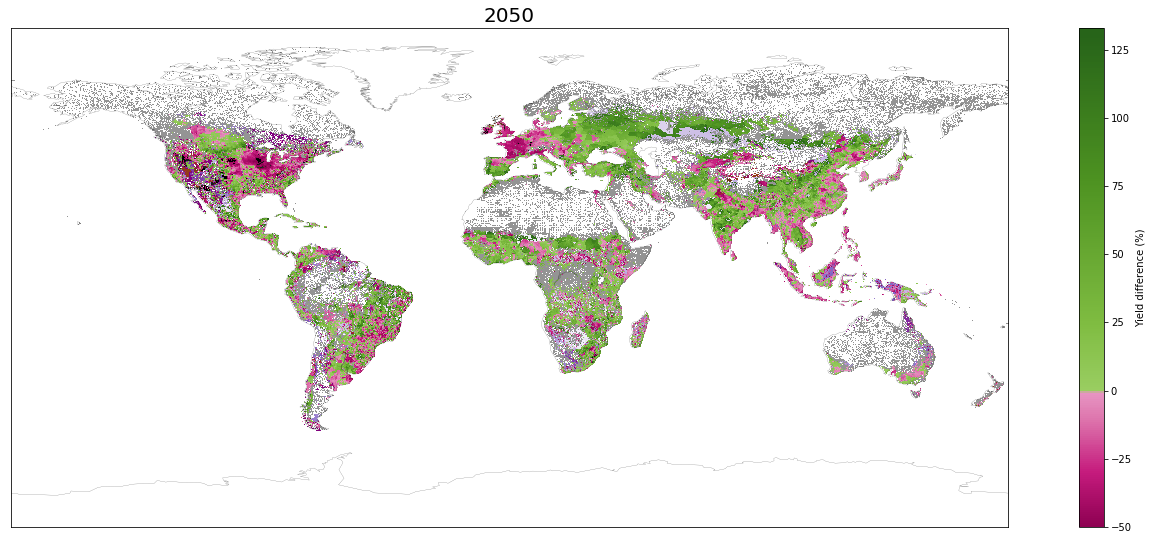

In [12]:
fig = plt.figure(figsize=(20, 8))

ax = plt.subplot()
title = '2050'
max_val=133
min_val = -50
visualize_changes_mean(100*new_df['change'], new_df['cal_per_ha_2000'], ssp, min_val, max_val, fig, ax, title, savefig=False)
fig.tight_layout(rect=[0, 0, 1, 0.95])

from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
    
dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
file_name = 'PurpleScaled400dpiDat_Vis_'+dt_string+'.png'
fig.savefig(file_name,dpi=400, bbox_inches='tight')